In [263]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import statistics
import matplotlib.pyplot as plt

# Load feature table

In [2]:
df = pd.read_csv('./data/feature_with_label_all_48H.csv')

In [150]:
df.shape

(277786, 338)

In [44]:
admissions_df = pd.read_csv('./data/admissions.csv')
admissions_df['HOSPITAL_EXPIRE_FLAG'].value_counts()

0    53122
1     5854
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64

In [56]:
admissions_df['ADMITTIME'] = pd.to_datetime(admissions_df['ADMITTIME'])
admissions_df['DISCHTIME'] = pd.to_datetime(admissions_df['DISCHTIME'])
admissions_df['length_of_stay'] = (admissions_df['DISCHTIME'] - admissions_df['ADMITTIME']) / np.timedelta64(1, 'h')
admissions_df.dtypes

index                            int64
ROW_ID                           int64
SUBJECT_ID                       int64
HADM_ID                          int64
ADMITTIME               datetime64[ns]
DISCHTIME               datetime64[ns]
DEATHTIME                       object
ADMISSION_TYPE                  object
ADMISSION_LOCATION              object
DISCHARGE_LOCATION              object
INSURANCE                       object
LANGUAGE                        object
RELIGION                        object
MARITAL_STATUS                  object
ETHNICITY                       object
EDREGTIME                       object
EDOUTTIME                       object
DIAGNOSIS                       object
HOSPITAL_EXPIRE_FLAG             int64
HAS_CHARTEVENTS_DATA             int64
length_of_stay                 float64
dtype: object

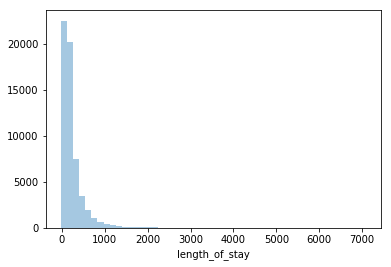

In [21]:
sns.distplot(admissions_df['length_of_stay'], kde=False)

In [36]:
g = sns.distplot(admissions_df['length_of_stay'],
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
ax = g.axes
ax.axhline(.9)
plt.show()

FigureCanvasNbAgg()

### Filter out stays less than 4 hours or longer than 21 days AND patient is alive

In [57]:
time_too_short = ((admissions_df['length_of_stay'] > 24 * 21) & (admissions_df['HOSPITAL_EXPIRE_FLAG'] == 0)) | (admissions_df['length_of_stay'] < 4)

,index,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HAS_CHARTEVENTS_DATA,length_of_stay
HOSPITAL_EXPIRE_FLAG,,,,,,,,,,,,,,,,,,,,
0,5455,5455,5455,5455,5455,5455,0,5455,5455,5455,5455,2576,5417,4040,5455,2399,2399,5455,5455,5455
1,968,968,968,968,968,968,968,968,968,968,968,459,952,867,968,553,553,968,968,968


In [58]:
admissions_filtered_time = admissions_df[~time_too_short]

In [281]:
df_filtered_time = df[df['HADM_ID'].isin(admissions_filtered_time['HADM_ID'])]
df_filtered_time.drop(columns=['HADM_ID', 'bin_num'], inplace=True)

/Users/chriszhou/anaconda/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [282]:
df_filtered_time.shape

(183085, 336)

### Remove Ethnicity

In [283]:
df_filtered_time = df_filtered_time.loc[:, ~df_filtered_time.columns.str.startswith('ethnicity')]

In [284]:
df_filtered_time['label'].value_counts()

0    178066
1      5019
Name: label, dtype: int64

# We see that the classes are extremely imbalanced. Two ways of dealing with imbalanced data

## 1. downsample majority class

In [222]:
from sklearn.utils import resample
df_majority = df_filtered_time[df_filtered_time.label==0]
df_minority = df_filtered_time[df_filtered_time.label==1]
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=10000,     # to match minority class
                                 random_state=123)
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
label_downsampled = df_downsampled['label'].copy()
df_downsampled.drop(columns=['label'], inplace=True)

## 2. upsample minority class

In [223]:
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=100000,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
label_upsampled = df_upsampled['label'].copy()
df_upsampled.drop(columns=['label'], inplace=True)

In [285]:
label_og = df_filtered_time['label'].copy()
df_og = df_filtered_time.drop(columns=['label'])

# Now we are ready to screen some hyperparameters
### Define methods for removing certain features

In [224]:
from sklearn.preprocessing import FunctionTransformer
abnormal_cols = df_filtered_time.columns[df_filtered_time.columns.str.startswith('abnormal')]
abnormal_ix = [
    list(df_filtered_time.columns).index(col)
    for col in abnormal_cols]
urine_ix = list(df_filtered_time.columns).index('Urine output_sum')
def urine_remover(X, remove_urine=False):
    if remove_urine:
        X = np.delete(X, urine_ix, axis=1)
    return X
def abnormal_lab_sum(X, sum_abnormal_lab=True):
    if sum_abnormal_lab:
        abnormal_labs = X[:, abnormal_ix]
        sum_abnormal = np.sum(abnormal_labs, axis=1)
        X = np.c_[X, sum_abnormal]
    return X
def remove_abnormal(X, remove_abnormal_lab=False):
    if remove_abnormal_lab:
        X = np.delete(X, abnormal_ix, axis=1)
    return X

In [225]:
from sklearn.base import BaseEstimator, TransformerMixin
class Percent_na_remover(BaseEstimator, TransformerMixin):
    def __init__(self, percent_na=.45):
        self.percent_na = percent_na
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        nanvals = np.isnan(X)
        nans_per_col = np.count_nonzero(nanvals, axis=0)
        ix_to_remove = []
        for ix, num_nans in enumerate(nans_per_col):
            if (num_nans / X.shape[0]) > self.percent_na:
                ix_to_remove.append(ix)
        X = np.delete(X, ix_to_remove, axis=1)
        return X

### Construct pipeline for prepping data

In [226]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
prep_pipeline = Pipeline([
    ('urine_remove', FunctionTransformer(urine_remover, validate=False, 
                                         kw_args={'remove_urine': False})),
    ('abnormal_sum', FunctionTransformer(abnormal_lab_sum, validate=False, 
                                         kw_args={'sum_abnormal_lab': True})),
    ('remove_abnormal_labs', FunctionTransformer(remove_abnormal, validate=False, 
                                         kw_args={'remove_abnormal_lab': False})),
    ('remove_na_percent', Percent_na_remover()),
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scalar', StandardScaler())
])

### To screen hyperparameters, we want one pipeline to feed into gridsearchCV

In [227]:
from sklearn.ensemble import RandomForestClassifier
prep_and_predict = Pipeline([
    ('prep', prep_pipeline),
    ('rnd', RandomForestClassifier(n_estimators=10, n_jobs=-1, verbose=2))
])

In [233]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

### parameter grid can be adjusted freely here

In [313]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = [{
    'prep__urine_remove__kw_args': [{'remove_urine': False}, {"remove_urine": True}],
    'prep__abnormal_sum__kw_args': [{'sum_abnormal_lab': False}, {"sum_abnormal_lab": True}],
    'prep__remove_abnormal_labs__kw_args': [{'remove_abnormal_lab': False}, {"remove_abnormal_lab": True}],
    'prep__remove_na_percent__percent_na': [.05, .1, .25, .4]
}]
grid_search = GridSearchCV(prep_and_predict, param_grid, cv=skf, n_jobs=-1, verbose=2, scoring='roc_auc')

### Tune hyperparameter with downsampled data to save time

In [314]:
grid_search.fit(df_downsampled.values, label_downsampled.values)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   22.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished


building tree 1 of 10building tree 2 of 10building tree 3 of 10building tree 4 of 10
building tree 5 of 10

building tree 6 of 10building tree 7 of 10

building tree 8 of 10


building tree 9 of 10
building tree 10 of 10


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('urine_remove', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function urine_remover at 0x1a288b3f28>, inv_kw_args=None,
          inverse_func=None, kw_args={'remove_urine': False},
          pass_y='deprecated', vali..._jobs=-1,
            oob_score=False, random_state=None, verbose=2,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'prep__urine_remove__kw_args': [{'remove_urine': False}, {'remove_urine': True}], 'prep__abnormal_sum__kw_args': [{'sum_abnormal_lab': False}, {'sum_abnormal_lab': True}], 'prep__remove_abnormal_labs__kw_args': [{'remove_abnormal_lab': False}, {'remove_abnormal_lab': True}], 'prep__remove_na_percent__percent_na': [0.05, 0.1, 0.25, 0.4]}],
       pre_dispatch='2*n_j

### After hyperparameter tuning, extract optimal model

We need to resplit data for final fitting

### Only run one of the 3 cells below

In [315]:
grid_search.best_params_

{'prep__abnormal_sum__kw_args': {'sum_abnormal_lab': False},
 'prep__remove_abnormal_labs__kw_args': {'remove_abnormal_lab': False},
 'prep__remove_na_percent__percent_na': 0.4,
 'prep__urine_remove__kw_args': {'remove_urine': False}}

In [250]:
# Splitting upsampled data
final_model = grid_search.best_estimator_
split = StratifiedKFold(n_splits=4, random_state=42)
for train_index, test_index in split.split(df_upsampled, label_upsampled):
    X_train = df_upsampled.iloc[train_index, :].values
    X_test = df_upsampled.iloc[test_index, :].values
    y_train = label_upsampled.iloc[train_index].values
    y_test = label_upsampled.iloc[test_index].values

In [296]:
# Splitting downsampled data
final_model = grid_search.best_estimator_
split = StratifiedKFold(n_splits=4, random_state=42)
for train_index, test_index in split.split(df_downsampled, label_downsampled):
    X_train = df_downsampled.iloc[train_index, :].values
    X_test = df_downsampled.iloc[test_index, :].values
    y_train = label_downsampled.iloc[train_index].values
    y_test = label_downsampled.iloc[test_index].values

In [286]:
# Splitting original data
final_model = grid_search.best_estimator_
split = StratifiedKFold(n_splits=4, random_state=42)
for train_index, test_index in split.split(df_og, label_og):
    X_train = df_og.iloc[train_index, :].values
    X_test = df_og.iloc[test_index, :].values
    y_train = label_og.iloc[train_index].values
    y_test = label_og.iloc[test_index].values

### Fitting final model with training set

In [316]:
final_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


building tree 1 of 10building tree 2 of 10building tree 3 of 10
building tree 4 of 10
building tree 5 of 10

building tree 6 of 10
building tree 7 of 10
building tree 8 of 10

building tree 9 of 10
building tree 10 of 10


Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('urine_remove', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function urine_remover at 0x1a288b3f28>, inv_kw_args=None,
          inverse_func=None, kw_args={'remove_urine': True},
          pass_y='deprecated', valid..._jobs=-1,
            oob_score=False, random_state=None, verbose=2,
            warm_start=False))])

In [317]:
from sklearn import metrics
y_pred = final_model.predict_proba(X_test)[:, 1]
prec_n, rec_n, _ = metrics.precision_recall_curve(y_test, y_pred)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


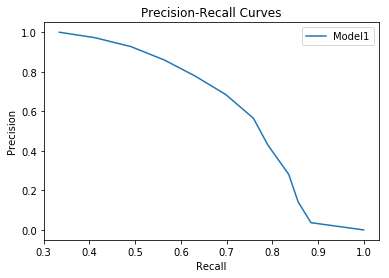

In [318]:
plt.plot(prec_n, rec_n, label = "Model1")
# plt.plot(prec2, rec2, label = "Model2")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()

In [319]:
y_pred_binary = final_model.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


In [320]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_binary)


array([[2275,  225],
       [ 546,  708]])

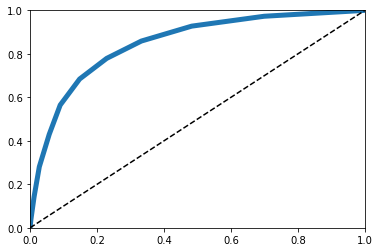

In [321]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=5, label=label)
    plt.plot([0, 1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    
plot_roc_curve(fpr, tpr)

# Anything below this is scratch work
### One option is to drop all rows containing any na

In [13]:
df_dropped_any = df_filtered_time.dropna()

In [14]:
df_dropped_any['label'].value_counts()

0    12897
1     3488
Name: label, dtype: int64

In [15]:
labels = df_dropped_any.pop('label').values
df_dropped_any = df_dropped_any.values

In [16]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42)

for train_index, test_index in skf.split(df_dropped_any, labels):
    X_train, X_test = df_dropped_any[train_index],df_dropped_any[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline
num_pipeline = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('std_scalar', StandardScaler())
])
X_train = num_pipeline.fit_transform(X_train)
X_test = num_pipeline.transform(X_test)

/Users/chriszhou/anaconda/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [43]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

In [44]:
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [49]:
y_pred = rnd_clf.predict_proba(X_test)[:, 1]

In [50]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

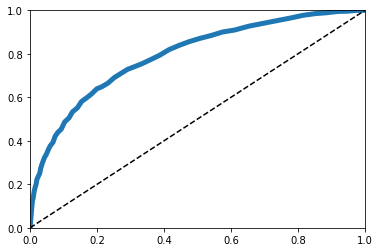

In [51]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=5, label=label)
    plt.plot([0, 1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    
plot_roc_curve(fpr, tpr)

In [52]:
prec1, rec1, thresholds1 = metrics.precision_recall_curve(y_test, y_pred)

### If we only drop urine and use median imputation

In [53]:
df_filtered_time.drop(columns=['Urine output_sum'], inplace=True)
labels = df_filtered_time.pop('label').values
df_filtered_time = df_filtered_time.values

AttributeError: 'numpy.ndarray' object has no attribute 'drop'

In [54]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42)

for train_index, test_index in skf.split(df_filtered_time, labels):
    X_train, X_test = df_filtered_time[train_index],df_filtered_time[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

In [55]:
X_train = num_pipeline.fit_transform(X_train)
X_test = num_pipeline.transform(X_test)

In [56]:
y_pred = rnd_clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]

In [57]:
prec2, rec2, thresholds2 = metrics.precision_recall_curve(y_test, y_pred)

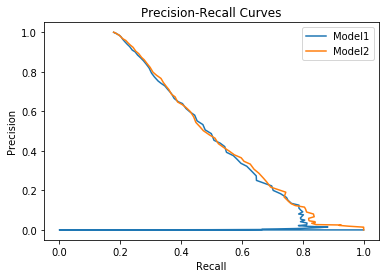

In [58]:
plt.plot(prec1, rec1, label = "Model1")
plt.plot(prec2, rec2, label = "Model2")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()

### SVMs

In [59]:
from sklearn.svm import LinearSVC
svm = LinearSVC(class_weight='balanced', C=1.0, verbose=2, max_iter=5000)

In [61]:
svm.fit(X_train, y_train)

[LibLinear]

/Users/chriszhou/anaconda/envs/py37/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=5000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=2)

In [62]:
y_pred = svm.decision_function(X_test)
prec3, rec3, thresholds3 = metrics.precision_recall_curve(y_test, y_pred)

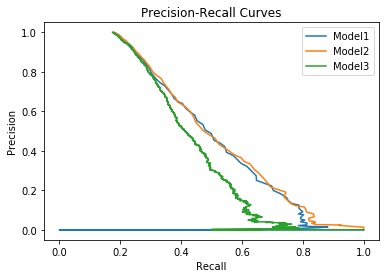

In [63]:
plt.plot(prec1, rec1, label = "Forest Drop all na")
plt.plot(prec2, rec2, label = "Forest impute median")
plt.plot(prec3, rec3, label = "SVM")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()

### Simple Neural Network

In [64]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neural_network import MLPClassifier
cv = StratifiedKFold(n_splits = 4)

param_grid = {
    'hidden_layer_sizes': [(50,), (50, 50), (50, 50, 50), (100, 100)]
}

In [65]:
bst_grid = GridSearchCV(
    estimator = MLPClassifier(),
    param_grid = param_grid,
    cv = cv,
    scoring = 'f1', 
    verbose = 3,
    n_jobs = -1)
bst_grid.fit(X_train, y_train)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:   56.5s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  1.7min remaining:   23.2s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'hidden_layer_sizes': [(50,), (50, 50), (50, 50, 50), (100, 100)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=3)

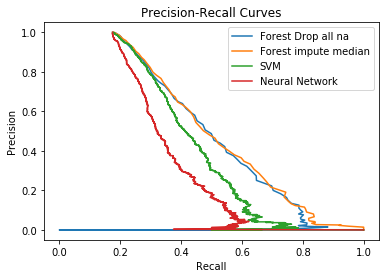

In [66]:
y_pred = bst_grid.best_estimator_.predict_proba(X_test)[:,1]
prec4, rec4, thresholds4 = metrics.precision_recall_curve(y_test, y_pred)
plt.plot(prec1, rec1, label = "Forest Drop all na")
plt.plot(prec2, rec2, label = "Forest impute median")
plt.plot(prec3, rec3, label = "SVM")
plt.plot(prec4, rec4, label = "Neural Network")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()


### Adaboost

In [74]:
from sklearn.ensemble import AdaBoostClassifier
rnd_clf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
ada_clf = AdaBoostClassifier(learning_rate=.5)

In [75]:
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=50, random_state=None)

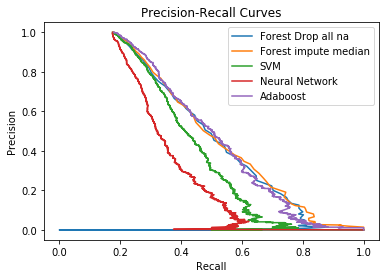

In [76]:
y_pred = ada_clf.predict_proba(X_test)[:, 1]
prec5, rec5, thresholds5 = metrics.precision_recall_curve(y_test, y_pred)
plt.plot(prec1, rec1, label = "Forest Drop all na")
plt.plot(prec2, rec2, label = "Forest impute median")
plt.plot(prec3, rec3, label = "SVM")
plt.plot(prec4, rec4, label = "Neural Network")
plt.plot(prec5, rec5, label = "Adaboost")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()

### Removed Abnormal Labs

In [77]:
df_filtered_time_only_abnormal_sum.drop(columns=['Urine output_sum'], inplace=True)
labels = df_filtered_time_only_abnormal_sum.pop('label').values
df_filtered_time_only_abnormal_sum = df_filtered_time_only_abnormal_sum.values

In [78]:
for train_index, test_index in skf.split(df_filtered_time, labels):
    X_train, X_test = df_filtered_time_only_abnormal_sum[train_index],df_filtered_time_only_abnormal_sum[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

In [79]:
X_train = num_pipeline.fit_transform(X_train)
X_test = num_pipeline.transform(X_test)
y_pred = rnd_clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]

In [80]:
prec7, rec7, thresholds7 = metrics.precision_recall_curve(y_test, y_pred)

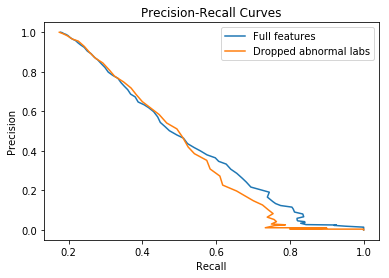

In [81]:
plt.plot(prec2, rec2, label = "Full features")
plt.plot(prec7, rec7, label = "Dropped abnormal labs")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()

In [82]:
X_train.shape

(23013, 71)